# Final Project - Evaluation of an Asian Option

This project is written in google colab, with the format of .ipynb and the kernel of R.

## 1.

In [ ]:
# Definition of basic parameters
T = 1
K = 1
sigma = 0.25
n = 100
t = seq(0,T,length.out = n+1)

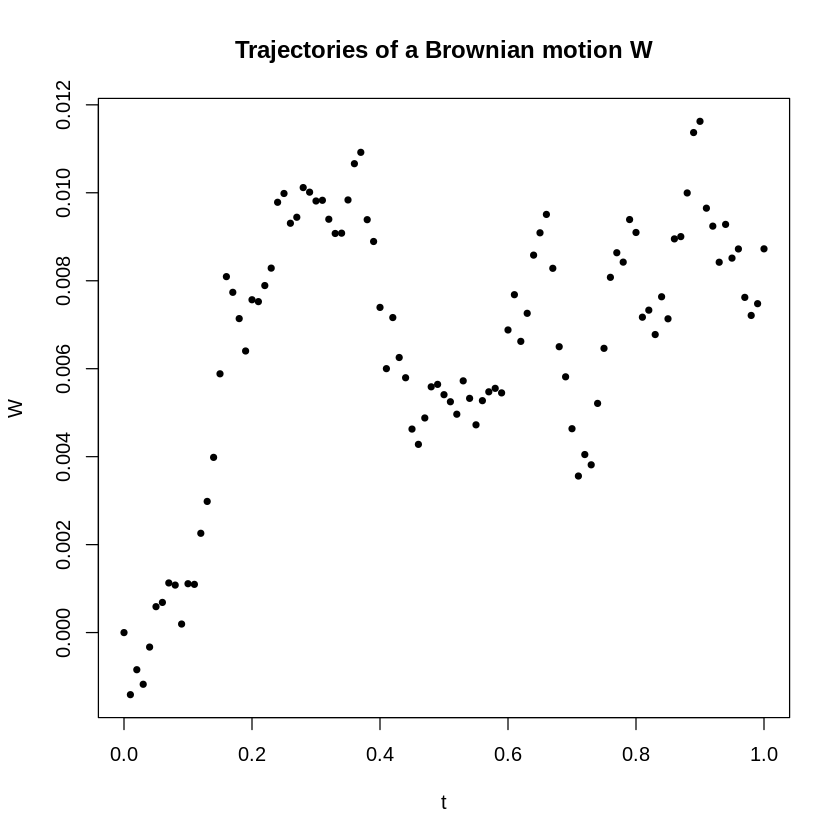

In [ ]:
# Simulate the trajectoiries of the Browian motion W
dW = rnorm(n, 0, T/n)*sqrt(T/n)
W0 = 0
W = c(W0, cumsum(dW))
plot(t,W, pch=20, main = "Trajectories of a Brownian motion W" )

In [ ]:
# Calculate the price E[G]
N = 1e4 # Number of simulations
dWs = matrix(rnorm(n*N, 0, 1)*sqrt(T/n), ncol=n) # Matrix whose rows are different simulations of dW

# Calculate the matrix whose rows are different simulations of S
Ss = matrix(0, nrow = N, ncol = n+1)
# New parameters
S0 = 1
r = 0
Ss[,1] = S0
for(i in 1:n){
  Ss[,i+1] = Ss[,i]*exp((r-sigma**2/2)*T/n+sigma*dWs[,i])
}

Gs = rowMeans(Ss)-K
Gs[Gs<0] = 0
E_G = mean(Gs)
print(E_G)
print(var(Gs))

[1] 0.05822033
[1] 0.008724456


## 2. Antithetic method

In [ ]:
# Define parameters
N <- 1e4  # Number of simulations
n <- 100  # Number of steps
T <- 1    # Time horizon
S0 <- 1 # Initial stock price
r <- 0 # Risk-free interest rate
sigma <- 0.25 # Volatility
K <- 1  # Strike price

# Generate antithetic paths for Brownian motion
dWs_anti <- matrix(rnorm(n*N, 0, 1)*sqrt(T/n), ncol = n)
dWs_anti <- cbind(dWs_anti, -dWs_anti) # Matrix with antithetic paths

# Generate stock price paths
Ss_anti <- matrix(0, nrow = N, ncol = 2*n + 2)
Ss_anti[, 1] <- S0
Ss_anti[, n+2] <- S0

for (i in 1:n) {
  Ss_anti[, i+1] <- Ss_anti[, i] * exp((r-sigma^2/2) * T/n + sigma * dWs_anti[, i])
  Ss_anti[, n+i+2] <- Ss_anti[, n+i+1] * exp((r-sigma^2/2) * T/n + sigma * dWs_anti[, n+i])
}

# Calculate option payoffs
Gs_anti <- apply(Ss_anti, 1, function(x) {
  (max(mean(x[2:(n+1)])-K, 0) + max(mean(x[(n+3):(2*n+2)])-K, 0))/2
})

# Calculate the expected option payoff and its variance
E_G_anti <- mean(Gs_anti)
Var_G_anti <- var(Gs_anti)

print(E_G_anti)
print(Var_G_anti)


[1] 0.05826777
[1] 0.002790952


## 3. Control variate method


In [ ]:
# Generate the matrix Ss and payoffs Gs
dWs = matrix(rnorm(n*N, 0, 1)*sqrt(T/n), ncol=n)
Ss = matrix(0, nrow = N, ncol = n+1)
S0 = 1
r = 0
Ss[,1] = S0
for(i in 1:n){
  Ss[,i+1] = Ss[,i]*exp((r-sigma**2/2)*T/n+sigma*dWs[,i])
}

Gs = rowMeans(Ss)-K
Gs[Gs<0] = 0
E_G = mean(Gs)

# Calculate the payoffs of the control variable
Gs_cv <- apply(Ss, 1, function(x) {
  geometric_mean = exp(mean(log(x[-1])))  # Calculate the mean value of logarithm and then turn back by exponential in order to avoid values too big
  max(geometric_mean - K, 0)
})

# Calculate the expected value and the variance
Cov_G_G_cv <- cov(Gs, Gs_cv)
rho <- Cov_G_G_cv / var(Gs_cv)

E_G_cv <- E_G - rho * (E_G - mean(Gs_cv))
Var_G_cv <- var(Gs) - 2*rho*cov(Gs, Gs_cv) + rho^2*var(Gs_cv)

print(E_G_cv)
print(Var_G_cv)

[1] 0.05646359
[1] 9.303588e-06


## 4. Importance sampling method

### (a)

In [ ]:
# Define a function g(Z)
g <- function(Z) {
  dt <- T/n
  t <- seq(dt, T, by = dt)
  St <- S0 * exp(cumsum((r - sigma^2 / 2) * dt + sigma * Z * sqrt(dt)))
  G <- max(mean(St) - K, 0)
  return(G)
}
Z <- rnorm(n)
G <- g(Z)

print(G)

[1] 0.2013661


### (b)

Let $ D = \{ z\in𝐑^n : g(z)>0 \}$. Let $f$ be the density of $Z$. For any $\mu$, let $h_\mu$ be the normal density with mean vector $\mu$ and covariance matrix $I_n$. Then we have $$ 𝔼[G] = 𝔼[g(Z)] = \int_{D}g(z)f(z)dz = \int_{D}g(z)\frac{f(z)}{h_\mu(z)}h_\mu(z)dz \\ = 𝔼_\mu\bigg[g(Z)\bigg(\frac{f(Z)}{h_\mu(Z)}\bigg)\bigg] = 𝔼_\mu\Big[g(Z)e^{-<\mu,Z>-<\mu,\mu>/2}\Big] = 𝔼\Big[g(Z+\mu)e^{-<\mu,Z>-<\mu,\mu>/2}\Big].$$ where $𝔼_\mu$ is the expectation with respect to $h_\mu$.

### (c)